In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet34
from torch.utils.data import DataLoader,random_split
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
torch.cuda.empty_cache()

In [2]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
BATCH_SIZE = 64
NUM_EPOCHS = 30
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
# PATIENCE = 5  # Early stopping patience
LABEL_SMOOTHING = 0.1
NUM_CLASSES = 10

# ========================
# DATA AUGMENTATION
# ========================
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder('directory/to/training/files', transform=train_transform) #<--- change the dir to match where your images are kept
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True ,num_workers=14)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True,num_workers=14)

# ========================
# MODEL
# ========================
model = resnet34(weights="IMAGENET1K_V1")  
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)  
model = model.to(device)

# ========================
# LOSS + OPTIMIZER
# ========================
loss_func = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# ========================
# TRAINING LOOP
# ========================
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(1, NUM_EPOCHS+1):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100

    # --------------------
    # Validation
    # --------------------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_correct / val_total * 100

    # --------------------
    # Checkpoint
    # --------------------
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), "best_model.pth")
        patience_counter = 0
        checkpoint_msg = "✅ Best model saved!"
    else:
        patience_counter += 1
        checkpoint_msg = ""
    
    end_time = time.time()
    epoch_time = end_time - start_time

    # --------------------
    # Pretty Logging
    # --------------------
    print(f"\nEpoch {epoch}/{NUM_EPOCHS} | Time: {epoch_time:.2f}s")
    print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}%")
    print(f"Val   Loss: {val_epoch_loss:.4f} | Val   Acc: {val_epoch_acc:.2f}% {checkpoint_msg}")

    # Early stopping
    # if patience_counter >= PATIENCE:
    #     print(f"\nEarly stopping triggered after {epoch} epochs.")
    #     break

print("\nTraining complete.")


Epoch 1/30 | Time: 19.47s
Train Loss: 1.1978 | Train Acc: 71.07%
Val   Loss: 1.2726 | Val   Acc: 68.30% ✅ Best model saved!

Epoch 2/30 | Time: 19.16s
Train Loss: 0.9735 | Train Acc: 81.02%
Val   Loss: 0.9953 | Val   Acc: 79.91% ✅ Best model saved!

Epoch 3/30 | Time: 19.32s
Train Loss: 0.8959 | Train Acc: 84.23%
Val   Loss: 0.9101 | Val   Acc: 83.73% ✅ Best model saved!

Epoch 4/30 | Time: 19.20s
Train Loss: 0.8452 | Train Acc: 86.44%
Val   Loss: 0.8797 | Val   Acc: 85.35% ✅ Best model saved!

Epoch 5/30 | Time: 19.25s
Train Loss: 0.8147 | Train Acc: 87.53%
Val   Loss: 0.8268 | Val   Acc: 86.97% ✅ Best model saved!

Epoch 6/30 | Time: 19.10s
Train Loss: 0.7868 | Train Acc: 88.66%
Val   Loss: 0.9039 | Val   Acc: 84.11% 

Epoch 7/30 | Time: 19.13s
Train Loss: 0.7645 | Train Acc: 89.71%
Val   Loss: 0.9130 | Val   Acc: 83.33% 

Epoch 8/30 | Time: 19.04s
Train Loss: 0.7570 | Train Acc: 90.12%
Val   Loss: 0.8316 | Val   Acc: 86.90% 

Epoch 9/30 | Time: 19.14s
Train Loss: 0.7400 | Train Acc

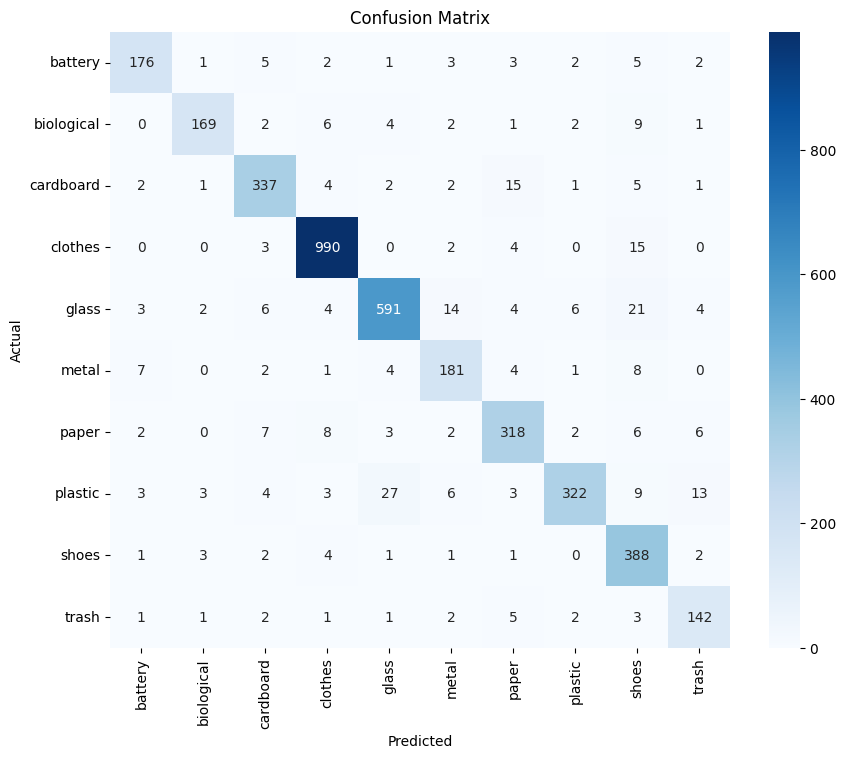


Classification Report:

              precision    recall  f1-score   support

     battery       0.90      0.88      0.89       200
  biological       0.94      0.86      0.90       196
   cardboard       0.91      0.91      0.91       370
     clothes       0.97      0.98      0.97      1014
       glass       0.93      0.90      0.92       655
       metal       0.84      0.87      0.86       208
       paper       0.89      0.90      0.89       354
     plastic       0.95      0.82      0.88       393
       shoes       0.83      0.96      0.89       403
       trash       0.83      0.89      0.86       160

    accuracy                           0.91      3953
   macro avg       0.90      0.90      0.90      3953
weighted avg       0.92      0.91      0.91      3953

Overall Accuracy:  91.42%
Overall Precision: 91.67%
Overall Recall:    91.42%
Overall F1 Score:  91.43%


In [ ]:
# Convert to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_predictions)

# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=train_dataset.dataset.classes, 
            yticklabels=train_dataset.dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 2. Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=train_dataset.dataset.classes))

# 3. Overall metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted")
rec = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print(f"Overall Accuracy:  {acc:.2%}")
print(f"Overall Precision: {prec:.2%}")
print(f"Overall Recall:    {rec:.2%}")
print(f"Overall F1 Score:  {f1:.2%}")
